## Transformación y preparación de features

Librerias

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from itertools import product
import json
import joblib

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error

Datos:

In [ ]:
PATH = "C:/Users/pauli/Documents/MetodosGranEscala/Prediccion_de-_demanda_en_retail/Data/"
#PATH = "/Users/monserratarredondo/GitHub/Prediccion_de-_demanda_en_retail/Data/"

item_categories = pd.read_csv(PATH + "item_categories.csv", encoding='utf-8', low_memory=False)
items= pd.read_csv(PATH + "items.csv", encoding='utf-8', low_memory=False)
sales_train = pd.read_csv(PATH + "sales_train.csv", encoding='utf-8', low_memory=False)
sample_submission = pd.read_csv(PATH + "sample_submission.csv", encoding='utf-8', low_memory=False)
shops = pd.read_csv(PATH + "shops.csv", encoding='utf-8', low_memory=False)
test = pd.read_csv(PATH + "test.csv", encoding='utf-8', low_memory=False)

print("sales_train:", sales_train.shape)
print("test:", test.shape)


sales_train: (2935849, 6)
test: (214200, 3)


Dataset mensual

In [9]:
sales = sales_train.copy()
sales["date"] = pd.to_datetime(sales["date"], format="%d.%m.%Y", errors="coerce")

# Limpieza
sales = sales[(sales["item_price"] > 0) & (sales["item_cnt_day"] >= 0)].copy()
sales["revenue_day"] = sales["item_price"] * sales["item_cnt_day"]

first_month = int(sales["date_block_num"].min())
last_month = int(sales["date_block_num"].max())
test_month = last_month + 1

print("Rango fechas:", sales["date"].min(), "→", sales["date"].max())
print("Meses train:", first_month, "→", last_month, "| Mes test:", test_month)

# Agregado mensual observado (target a nivel tienda–producto–mes)
month_sales = (
    sales
    .groupby(["date_block_num", "shop_id", "item_id"], as_index=False)
    .agg(
        item_cnt_month=("item_cnt_day", "sum"),   # target
        item_price_mean=("item_price", "mean"),
        revenue_month=("revenue_day", "sum"),
    )
)

month_sales.head()


Rango fechas: 2013-01-01 00:00:00 → 2015-10-31 00:00:00
Meses train: 0 → 33 | Mes test: 34


,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean,revenue_month
0,0,0,32,6.0,221.0,1326.0
1,0,0,33,3.0,347.0,1041.0
2,0,0,35,1.0,247.0,247.0
3,0,0,43,1.0,221.0,221.0
4,0,0,51,2.0,128.5,257.0


In [10]:
# Grid por mes: shops_del_mes x items_del_mes
# Así aparecen combinaciones con 0 ventas (que en el train no aparecen “naturalmente”).

grid = []
for m in range(first_month, last_month + 1):
    cur = sales[sales["date_block_num"] == m]
    cur_shops = cur["shop_id"].unique()
    cur_items = cur["item_id"].unique()
    grid.append(np.array(list(product([m], cur_shops, cur_items)), dtype=np.int32))

matrix = pd.DataFrame(np.vstack(grid), columns=["date_block_num", "shop_id", "item_id"])

# Mes de test: usamos EXACTAMENTE los pares del test.csv
test_pairs = test[["shop_id", "item_id"]].copy()
test_pairs["date_block_num"] = test_month
matrix = pd.concat([matrix, test_pairs[["date_block_num", "shop_id", "item_id"]]], ignore_index=True)

# Merge de ventas + fill de ceros
matrix = matrix.merge(month_sales, on=["date_block_num", "shop_id", "item_id"], how="left")

for c in ["item_cnt_month", "item_price_mean", "revenue_month"]:
    matrix[c] = matrix[c].fillna(0).astype(np.float32)

# Categoría siempre viene de items (no depende de ventas)
cat_map = items.set_index("item_id")["item_category_id"]
matrix["item_category_id"] = matrix["item_id"].map(cat_map).astype(np.int16)

# Clip recomendado por Kaggle
matrix["item_cnt_month"] = matrix["item_cnt_month"].clip(0, 20)

print("matrix:", matrix.shape)
print("Proporción de ceros (train):", (matrix.loc[matrix["date_block_num"] <= last_month, "item_cnt_month"] == 0).mean().round(4))
matrix.head()


matrix: (11098754, 7)
Proporción de ceros (train): 0.8522


,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean,revenue_month,item_category_id
0,0,59,22154,1.0,999.0,999.0,37
1,0,59,2552,0.0,0.0,0.0,58
2,0,59,2554,0.0,0.0,0.0,58
3,0,59,2555,0.0,0.0,0.0,56
4,0,59,2564,0.0,0.0,0.0,59


Features de calendario (mes/año):

In [11]:
matrix["month"] = (matrix["date_block_num"] % 12).astype(np.int8)
matrix["year"] = (2013 + matrix["date_block_num"] // 12).astype(np.int16)

matrix[["date_block_num","year","month"]].drop_duplicates().head(15)


,date_block_num,year,month
0,0,2013,0
364950,1,2013,1
740586,2,2013,2
1122386,3,2013,3
1488686,4,2013,4
1863851,5,2013,5
2253655,6,2013,6
2640239,7,2013,7
3001274,8,2013,8
3355604,9,2013,9


Features con historia (lags):

In [13]:
# Si re-ejecutas la celda, primero limpia columnas viejas para no duplicar
cols_old = [c for c in matrix.columns if "lag_" in c] + ["shop_mean_lag_1", "item_mean_lag_1", "cat_mean_lag_1"]
matrix = matrix.drop(columns=cols_old, errors="ignore")

def add_lags(df, lags, cols):
    df = df.copy()
    key = ["date_block_num", "shop_id", "item_id"]
    for lag in lags:
        tmp = df[key + cols].copy()
        tmp["date_block_num"] = tmp["date_block_num"] + lag
        tmp = tmp.rename(columns={c: f"{c}_lag_{lag}" for c in cols})
        df = df.merge(tmp, on=key, how="left")
    return df

lags = [1, 2, 3, 6, 12]
matrix = add_lags(matrix, lags, cols=["item_cnt_month", "item_price_mean"])

def add_group_mean_lag(df, group_cols, col, lag=1, name=None):
    if name is None:
        name = "_".join(group_cols) + f"_{col}_mean_lag_{lag}"

    g = (
        df.groupby(["date_block_num"] + group_cols, as_index=False)[col]
        .mean()
        .rename(columns={col: name})
    )
    g["date_block_num"] = g["date_block_num"] + lag
    return df.merge(g, on=["date_block_num"] + group_cols, how="left")

matrix = add_group_mean_lag(matrix, ["shop_id"], "item_cnt_month", lag=1, name="shop_mean_lag_1")
matrix = add_group_mean_lag(matrix, ["item_id"], "item_cnt_month", lag=1, name="item_mean_lag_1")
matrix = add_group_mean_lag(matrix, ["item_category_id"], "item_cnt_month", lag=1, name="cat_mean_lag_1")

# Columnas lag (sin duplicados)
lag_cols = [c for c in matrix.columns if "lag_" in c] + ["shop_mean_lag_1", "item_mean_lag_1", "cat_mean_lag_1"]
lag_cols = list(dict.fromkeys(lag_cols))  # dedup, conserva orden

# Relleno de NA: al inicio de la historia no hay lags -> 0
matrix[lag_cols] = matrix[lag_cols].fillna(0).astype(np.float32)

print("Lags listos:", len(lag_cols), "columnas")
matrix.head()


Lags listos: 13 columnas


,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean,revenue_month,item_category_id,month,year,item_cnt_month_lag_1,...,item_price_mean_lag_2,item_cnt_month_lag_3,item_price_mean_lag_3,item_cnt_month_lag_6,item_price_mean_lag_6,item_cnt_month_lag_12,item_price_mean_lag_12,shop_mean_lag_1,item_mean_lag_1,cat_mean_lag_1
0,0,59,22154,1.0,999.0,999.0,37,0,2013,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,59,2552,0.0,0.0,0.0,58,0,2013,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,59,2554,0.0,0.0,0.0,58,0,2013,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,59,2555,0.0,0.0,0.0,56,0,2013,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,59,2564,0.0,0.0,0.0,59,0,2013,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Split train/valid (por tiempo) + baseline:

In [14]:
def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

valid_month = last_month

train_mask = matrix["date_block_num"] < valid_month
valid_mask = matrix["date_block_num"] == valid_month
test_mask  = matrix["date_block_num"] == test_month

feature_cols = [
    "shop_id", "item_id", "item_category_id",
    "month", "year",
] + lag_cols

X_train = matrix.loc[train_mask, feature_cols]
y_train = matrix.loc[train_mask, "item_cnt_month"]

X_valid = matrix.loc[valid_mask, feature_cols]
y_valid = matrix.loc[valid_mask, "item_cnt_month"]

print("Train:", X_train.shape, "Valid:", X_valid.shape)

# Baseline: "igual que el mes pasado"
pred_bl = X_valid["item_cnt_month_lag_1"].values
print("RMSE baseline (lag_1):", round(rmse(y_valid, pred_bl), 4))


Train: (10646470, 18) Valid: (238084, 18)
RMSE baseline (lag_1): 1.1365


Modelo (baseline sólido): HistGradientBoostingRegressor

In [15]:
model = HistGradientBoostingRegressor(
    loss="squared_error",
    max_depth=8,
    learning_rate=0.08,
    max_iter=400,
    random_state=42
)

model.fit(X_train, y_train)

pred_valid = model.predict(X_valid).clip(0, 20)
print("RMSE valid:", round(rmse(y_valid, pred_valid), 4))


RMSE valid: 0.9098


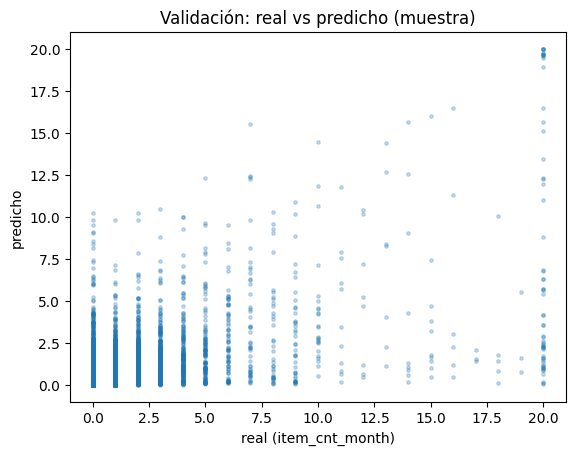

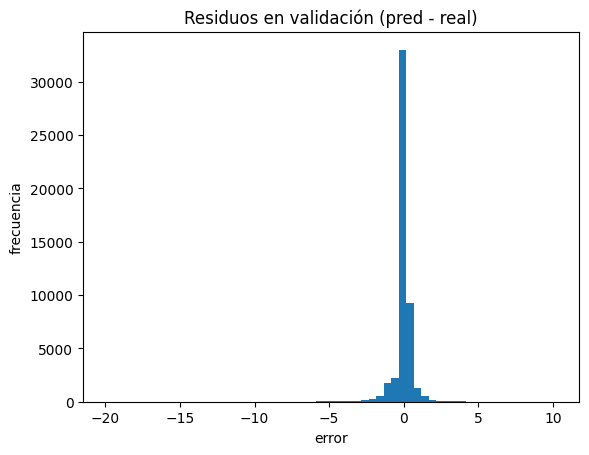

In [16]:
# Visual rápido (muestra)
n = min(50000, len(y_valid))
rng = np.random.RandomState(42)
idx = rng.choice(len(y_valid), size=n, replace=False)

plt.figure()
plt.scatter(y_valid.values[idx], pred_valid[idx], s=6, alpha=0.25)
plt.title("Validación: real vs predicho (muestra)")
plt.xlabel("real (item_cnt_month)")
plt.ylabel("predicho")
plt.show()

res = pred_valid[idx] - y_valid.values[idx]
plt.figure()
plt.hist(res, bins=60)
plt.title("Residuos en validación (pred - real)")
plt.xlabel("error")
plt.ylabel("frecuencia")
plt.show()


Entrenar final y generar submission para Kaggle:

In [17]:
# Entrenamos con TODO lo disponible (hasta el último mes real)
X_full = matrix.loc[matrix["date_block_num"] <= valid_month, feature_cols]
y_full = matrix.loc[matrix["date_block_num"] <= valid_month, "item_cnt_month"]

model_final = HistGradientBoostingRegressor(
    loss="squared_error",
    max_depth=8,
    learning_rate=0.08,
    max_iter=400,
    random_state=42
)

model_final.fit(X_full, y_full)

print("Modelo final entrenado.")
print("Filas usadas:", X_full.shape[0], "| Features:", X_full.shape[1])

Modelo final entrenado.
Filas usadas: 10884554 | Features: 18


Helpers y baseline

In [19]:
# Baseline: "igual que el mes pasado" (lag 1 del target)

preds  = {} if "preds"  not in globals() else preds
scores = {} if "scores" not in globals() else scores

pred_bl = X_valid["item_cnt_month_lag_1"].values
pred_bl = np.clip(pred_bl, 0, 20)

preds["Baseline (lag_1)"]  = pred_bl
scores["Baseline (lag_1)"] = rmse(y_valid, pred_bl)

print("RMSE baseline (lag_1):", round(scores["Baseline (lag_1)"], 4))

RMSE baseline (lag_1): 1.1365


In [20]:
# Modelo 2: Ridge (lineal, rápido, sirve como contraste)

from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

pred_ridge = ridge.predict(X_valid)
pred_ridge = np.clip(pred_ridge, 0, 20)

preds["Ridge"]  = pred_ridge
scores["Ridge"] = rmse(y_valid, pred_ridge)

print("RMSE Ridge:", round(scores["Ridge"], 4))


RMSE Ridge: 0.9698


In [21]:
# Modelo 3: PoissonRegressor (pensado para conteos)

from sklearn.linear_model import PoissonRegressor

pois = PoissonRegressor(alpha=1e-4, max_iter=200)
pois.fit(X_train, y_train)

pred_pois = pois.predict(X_valid)
pred_pois = np.clip(pred_pois, 0, 20)

preds["PoissonRegressor"]  = pred_pois
scores["PoissonRegressor"] = rmse(y_valid, pred_pois)

print("RMSE PoissonRegressor:", round(scores["PoissonRegressor"], 4))


c:\Users\pauli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_linear_loss.py:295: RuntimeWarning: invalid value encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights


RMSE PoissonRegressor: 1.138


,model,rmse
0,Ridge,0.969765
1,Baseline (lag_1),1.136535
2,PoissonRegressor,1.137964


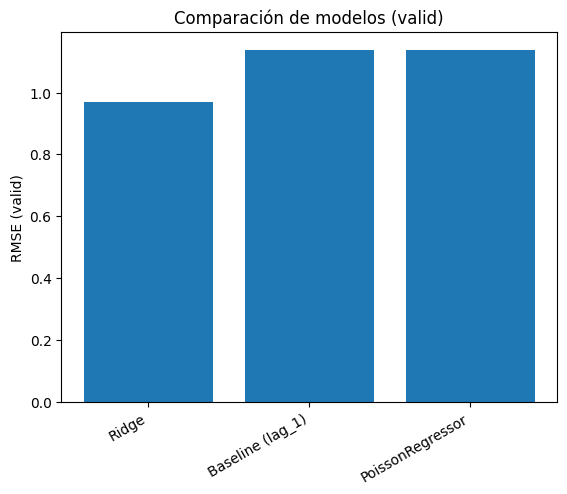

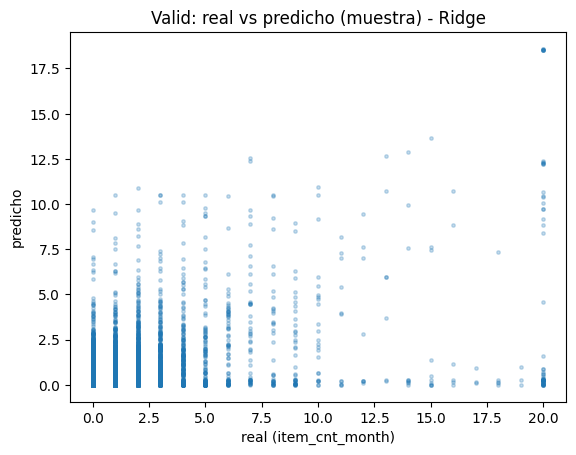

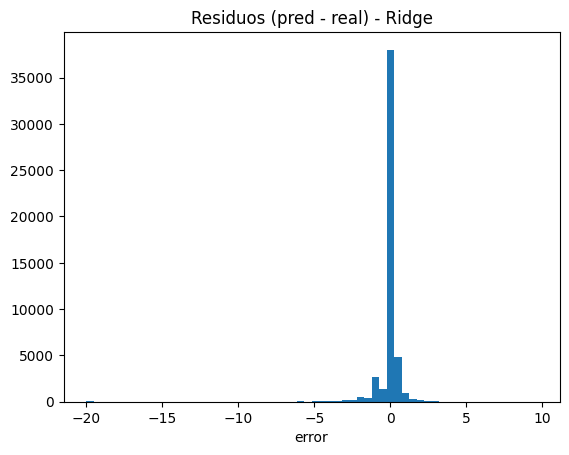

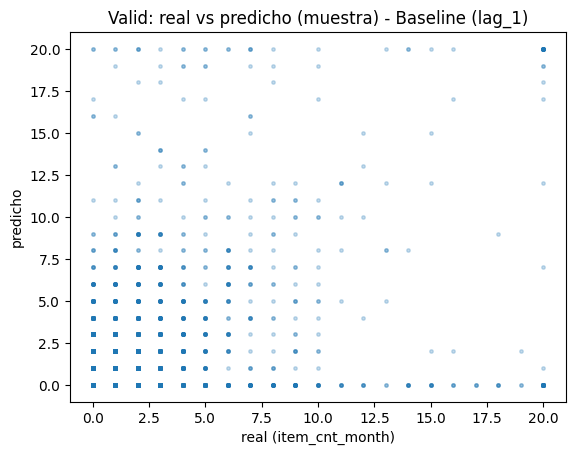

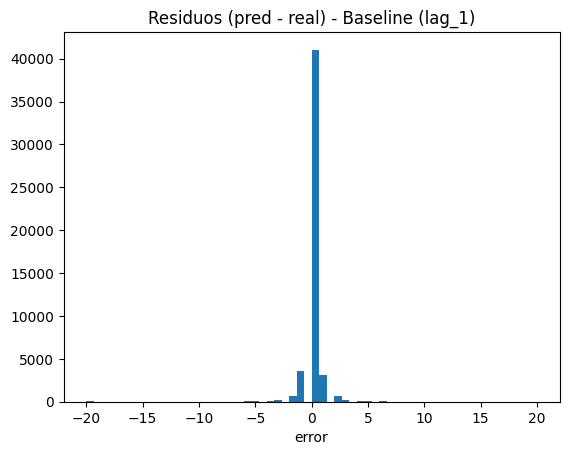

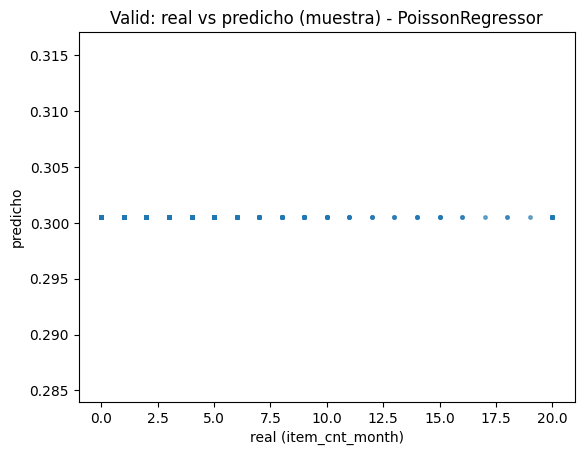

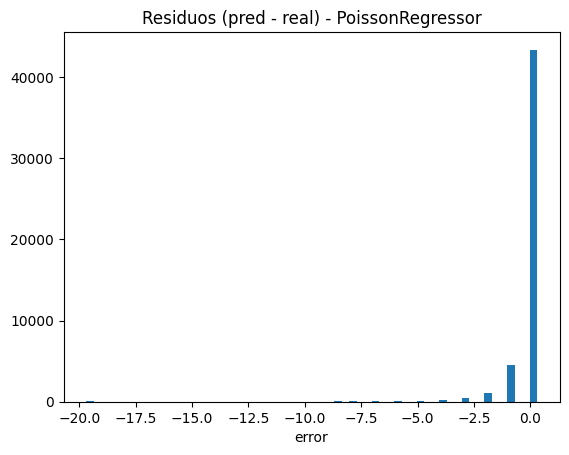

In [22]:
# Comparación rápida (tabla + gráficas)

results = (
    pd.DataFrame({"model": list(scores.keys()), "rmse": list(scores.values())})
    .sort_values("rmse")
    .reset_index(drop=True)
)

display(results)

plt.figure()
plt.bar(results["model"], results["rmse"])
plt.xticks(rotation=30, ha="right")
plt.ylabel("RMSE (valid)")
plt.title("Comparación de modelos (valid)")
plt.show()

# Mismo sample para todos
n = min(50000, len(y_valid))
rng = np.random.RandomState(42)
idx = rng.choice(len(y_valid), size=n, replace=False)

top_models = results["model"].head(3).tolist()

for name in top_models:
    y = y_valid.values[idx]
    p = preds[name][idx]

    plt.figure()
    plt.scatter(y, p, s=6, alpha=0.25)
    plt.title(f"Valid: real vs predicho (muestra) - {name}")
    plt.xlabel("real (item_cnt_month)")
    plt.ylabel("predicho")
    plt.show()

    plt.figure()
    plt.hist(p - y, bins=60)
    plt.title(f"Residuos (pred - real) - {name}")
    plt.xlabel("error")
    plt.show()
